<a href="https://colab.research.google.com/github/RefenRefen/hello-pytorch/blob/master/5_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torchvision
from torch import nn
import os
from __future__ import print_function
from torchvision import transforms, models, datasets
import torch.nn as nn
import time
import copy
import torchsummary
from torchvision. models import ResNet18_Weights

In [15]:
print(torch.__version__)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties('cuda'))

1.13.0+cu116
Tesla T4
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#Initialization

In [17]:
batch_size = 256
num_classes = 10
num_epoch = 10

#Dataset

In [18]:
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10('./train', train=True, transform=transform, target_transform=None, download=True)

test_dataset = torchvision.datasets.CIFAR10('./test', train=False, transform=transform, target_transform=None, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [19]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_loader,
                    'val': test_loader}

In [20]:
from torchvision.transforms.transforms import Grayscale
one_train_batch_imgs, one_train_batch_lbls = next(iter(train_loader))
one_train_batch_imgs = one_train_batch_imgs.to(device)
one_train_batch_lbls = one_train_batch_lbls.to(device)
# print(one_train_batch_imgs.shape)
# print(one_train_batch_lbls)
img1 = one_train_batch_imgs[0]
import matplotlib.pyplot as plt
# plt.imshow(img1[0])
print(one_train_batch_lbls[0].item())

6


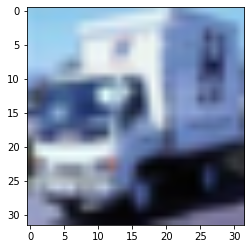

In [21]:
import numpy as np

idx = torch.randint(0, batch_size, size=(1,))
img = one_train_batch_imgs[idx, ...].squeeze(0)
img = np.moveaxis(img.cpu().numpy(), 0, -1)
img.shape
# plt.imshow()
plt.imshow(img, interpolation='bilinear')

In [22]:
# for batch_number ,(image, labels) in enumerate(train_loader):
#     print(batch_number, image.shape)


In [23]:
def vis(imgs, idx):
    # idx = torch.randint(0, batch_size, size=(1,))
    img = imgs[idx, ...].abs().sum(1).squeeze(0)
    img = np.moveaxis(img.cpu().detach().numpy(), 0, -1)
    plt.imshow(img, interpolation='bilinear')
    plt.show()

#Model

In [24]:
backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)

layers = list(backbone.children())
l1 = nn.Sequential(*layers[:-5])
# print(l1)

l2 = nn.Sequential(*layers[5])
# print(l2)

l3 = nn.Sequential(*layers[6])
# print(l3)

l4 = nn.Sequential(*layers[7:9])
# print(l4)

l5 = nn.Sequential(layers[9])
print(l5)

Sequential(
  (0): Linear(in_features=512, out_features=1000, bias=True)
)


In [51]:
imgs, lbls = next(iter(dataloaders_dict['train']))
imgs = imgs.to(device)
lbls = lbls.to(device)

idx = torch.randint(0, batch_size, size=(1,))
y1 = l1(imgs)
print(y1.shape)
# vis(y1, idx)

y2 = l2(y1)
print(y2.shape)

y3 = l3(y2)
print(y3.shape)

y4 = l4(y3)
print(y4.shape)

n1 = nn.Conv2d(in_channels=64, out_channels=512, kernel_size=1, stride=8).to(device)
z1 = n1(y1) * y4
z1 = z1.view(z1.size(0), -1)
print('z1:', z1.shape)

n2 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=1, stride=4).to(device)
z2 = n2(y2) * y4
z2 = z2.view(z2.size(0), -1)
print('z2:', z2.shape)

n3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=2, stride=4).to(device)
z3 = n3(y3) * y4
z3 = z3.view(z3.size(0), -1)
print('z3:', z3.shape)


zt = torch.cat((z1, z2, z3), dim=1)

fc = nn.Linear(in_features=512*3, out_features=10, bias=False).to(device)
output = fc(zt)
output.shape



torch.Size([256, 64, 8, 8])
torch.Size([256, 128, 4, 4])
torch.Size([256, 256, 2, 2])
torch.Size([256, 512, 1, 1])
z1: torch.Size([256, 512])
z2: torch.Size([256, 512])
z3: torch.Size([256, 512])


torch.Size([256, 10])

In [52]:
l1[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [26]:
from torchvision.models.resnet import ResNet18_Weights
class convnet(nn.Module):
    def __init__(self, num_class):
        super(convnet, self).__init__()
        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Linear(in_features=512, out_features=10, bias=False)

    def forward(self, x):
        y = self.backbone(x)
        return y
        

In [27]:
model_ = convnet(num_classes).to(device)
print(model_)
# torchsummary.summary(model_, (3, 32, 32))

convnet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [28]:
y = model_(one_train_batch_imgs)
y[idx, ...]

tensor([[-0.0151, -0.0631,  0.4233, -0.3502, -0.6242, -0.1918, -0.2445, -0.0549,
          0.3999,  0.0601]], device='cuda:0', grad_fn=<IndexBackward0>)

In [29]:
model_.backbone.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [30]:
for name, param in model_.named_parameters():
    print(name)

backbone.conv1.weight
backbone.bn1.weight
backbone.bn1.bias
backbone.layer1.0.conv1.weight
backbone.layer1.0.bn1.weight
backbone.layer1.0.bn1.bias
backbone.layer1.0.conv2.weight
backbone.layer1.0.bn2.weight
backbone.layer1.0.bn2.bias
backbone.layer1.1.conv1.weight
backbone.layer1.1.bn1.weight
backbone.layer1.1.bn1.bias
backbone.layer1.1.conv2.weight
backbone.layer1.1.bn2.weight
backbone.layer1.1.bn2.bias
backbone.layer2.0.conv1.weight
backbone.layer2.0.bn1.weight
backbone.layer2.0.bn1.bias
backbone.layer2.0.conv2.weight
backbone.layer2.0.bn2.weight
backbone.layer2.0.bn2.bias
backbone.layer2.0.downsample.0.weight
backbone.layer2.0.downsample.1.weight
backbone.layer2.0.downsample.1.bias
backbone.layer2.1.conv1.weight
backbone.layer2.1.bn1.weight
backbone.layer2.1.bn1.bias
backbone.layer2.1.conv2.weight
backbone.layer2.1.bn2.weight
backbone.layer2.1.bn2.bias
backbone.layer3.0.conv1.weight
backbone.layer3.0.bn1.weight
backbone.layer3.0.bn1.bias
backbone.layer3.0.conv2.weight
backbone.layer

In [31]:
# freezing some layers
for name, param in model_.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
        print(name)
    else:
        param.requires_grad = False


backbone.fc.weight


In [32]:
flag = False
for name, param in model_.named_parameters():
    if 'layer3.0' in name or flag:
        param.requires_grad = True
        print(name)
        flag = True
    else:
        param.requires_grad = False


backbone.layer3.0.conv1.weight
backbone.layer3.0.bn1.weight
backbone.layer3.0.bn1.bias
backbone.layer3.0.conv2.weight
backbone.layer3.0.bn2.weight
backbone.layer3.0.bn2.bias
backbone.layer3.0.downsample.0.weight
backbone.layer3.0.downsample.1.weight
backbone.layer3.0.downsample.1.bias
backbone.layer3.1.conv1.weight
backbone.layer3.1.bn1.weight
backbone.layer3.1.bn1.bias
backbone.layer3.1.conv2.weight
backbone.layer3.1.bn2.weight
backbone.layer3.1.bn2.bias
backbone.layer4.0.conv1.weight
backbone.layer4.0.bn1.weight
backbone.layer4.0.bn1.bias
backbone.layer4.0.conv2.weight
backbone.layer4.0.bn2.weight
backbone.layer4.0.bn2.bias
backbone.layer4.0.downsample.0.weight
backbone.layer4.0.downsample.1.weight
backbone.layer4.0.downsample.1.bias
backbone.layer4.1.conv1.weight
backbone.layer4.1.bn1.weight
backbone.layer4.1.bn1.bias
backbone.layer4.1.conv2.weight
backbone.layer4.1.bn2.weight
backbone.layer4.1.bn2.bias
backbone.fc.weight


In [33]:
model_.backbone.fc

Linear(in_features=512, out_features=10, bias=False)

#Config

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_.parameters(), lr=0.001, momentum=0.9)


In [35]:
dataloaders_dict['train']

# Trainer

In [36]:
# for epoch in range(num_epoch):
    
#     print('Epoch {}/{}'.format(epoch, num_epoch - 1))
#     print('-' * 10)

#     for phase in ['train', 'val']:
        
#         running_loss = 0
#         running_corrects = 0

#         for inputs, labels in dataloaders_dict[phase]:
            
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             optimizer.zero_grad()

#             outputs = model_(inputs) # (256, 10)
#             loss = criterion(outputs, labels)
#             _, preds = torch.max(outputs, 1) # preds contains the index of maxmimum in 10 output for each record (256,)

#             if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
            
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
            
#         epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
#         epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)

#         print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))





In [37]:
# len(dataloaders_dict[phase].dataset)

In [38]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # if phase == 'train':
            #     model.train()  # Set model to training mode
            # else:
            #     model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [39]:
model_ft, hist = train_model(model_, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.4628 Acc: 0.4869
val Loss: 1.1357 Acc: 0.5958

Epoch 1/9
----------
train Loss: 0.9682 Acc: 0.6608
val Loss: 0.9985 Acc: 0.6464

Epoch 2/9
----------
train Loss: 0.7919 Acc: 0.7206
val Loss: 0.9433 Acc: 0.6739

Epoch 3/9
----------
train Loss: 0.6664 Acc: 0.7678
val Loss: 0.9200 Acc: 0.6830

Epoch 4/9
----------
train Loss: 0.5632 Acc: 0.8052
val Loss: 0.9198 Acc: 0.6918

Epoch 5/9
----------
train Loss: 0.4635 Acc: 0.8432
val Loss: 0.9459 Acc: 0.6904

Epoch 6/9
----------
train Loss: 0.3716 Acc: 0.8783
val Loss: 0.9693 Acc: 0.6964

Epoch 7/9
----------
train Loss: 0.2915 Acc: 0.9068
val Loss: 1.0287 Acc: 0.6940

Epoch 8/9
----------
train Loss: 0.2196 Acc: 0.9351
val Loss: 1.0936 Acc: 0.6910

Epoch 9/9
----------
train Loss: 0.1627 Acc: 0.9554
val Loss: 1.1499 Acc: 0.6947

Training complete in 1m 52s
Best val Acc: 0.696400
